In [23]:
import pandas as pd          #For dataframe related operations
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
import datetime as dt  # To access datetime
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [ ]:
#This is preprocessing and reading of file which would be avoided as the file size is too high thus 
# takes a lot of time to load. We would instead use summarized version of the file as done below.
raw = pd.read_csv('rides.csv',parse_dates=['EntryDateTime','ExitDateTime'])
raw.info()
raw.head()
raw_dp=raw.drop(['TripNumber','LicensePlate','PickupDropoffDateTime','MatchedRide','MultiPartyTrips','LongitudeLatitude','EGGRGramsCO2PerMile','GGR','NumberOfParties'],axis=1)
raw_dp.info()
raw_dp['Count']=1


C:\Users\harsh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
raw_dp=pd.read_csv('Rideshare_timeseries.csv',parse_dates=['EntryDateTime','ExitDateTime'])

In [4]:
raw_ts=raw_dp[['EntryDateTime','Count']]

In [5]:
raw_ts.index=raw_ts.EntryDateTime
raw_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 920377 entries, 2018-04-30 22:53:00 to 2018-06-30 23:46:00
Data columns (total 2 columns):
EntryDateTime    917448 non-null datetime64[ns]
Count            920377 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 21.1 MB


In [13]:
hourly_raw = raw_ts.resample('H').sum()

In [14]:
hourly_raw.head()

,Count
EntryDateTime,
2017-12-02 15:00:00,478
2017-12-02 16:00:00,2531
2017-12-02 17:00:00,1374
2017-12-02 18:00:00,1468
2017-12-02 19:00:00,1280


In [16]:
hourly_raw['TimeStamp']=pd.to_datetime(hourly_raw.index)
hourly_raw=hourly_raw[['TimeStamp','Count']]
hourly_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5049 entries, 2017-12-02 15:00:00 to 2018-06-30 23:00:00
Data columns (total 2 columns):
TimeStamp    5049 non-null datetime64[ns]
Count        5049 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 118.3 KB


In [17]:
hourly_raw.head()

,TimeStamp,Count
EntryDateTime,,
2017-12-02 15:00:00,2017-12-02 15:00:00,478
2017-12-02 16:00:00,2017-12-02 16:00:00,2531
2017-12-02 17:00:00,2017-12-02 17:00:00,1374
2017-12-02 18:00:00,2017-12-02 18:00:00,1468
2017-12-02 19:00:00,2017-12-02 19:00:00,1280


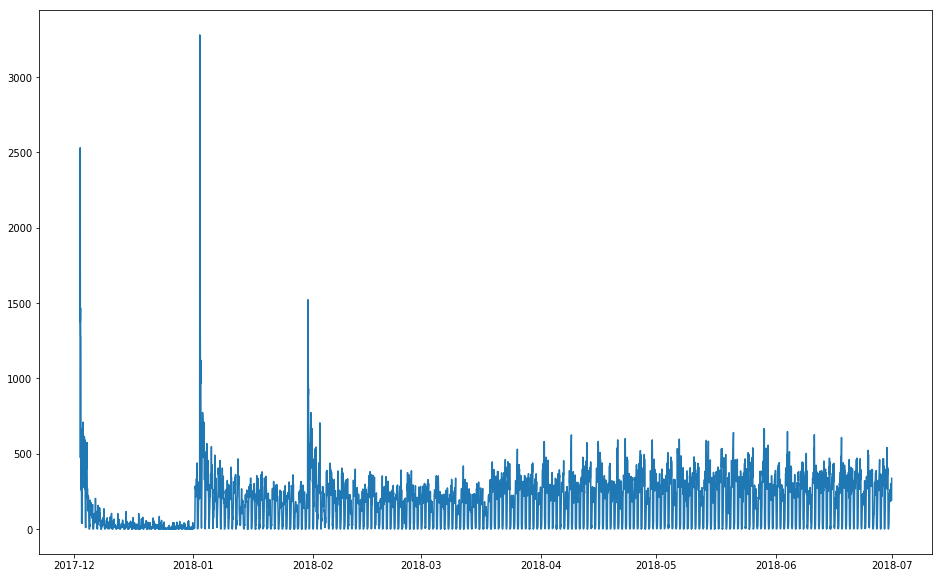

In [18]:
plt.figure(figsize=(16,10))
plt.plot(hourly_raw.Count)

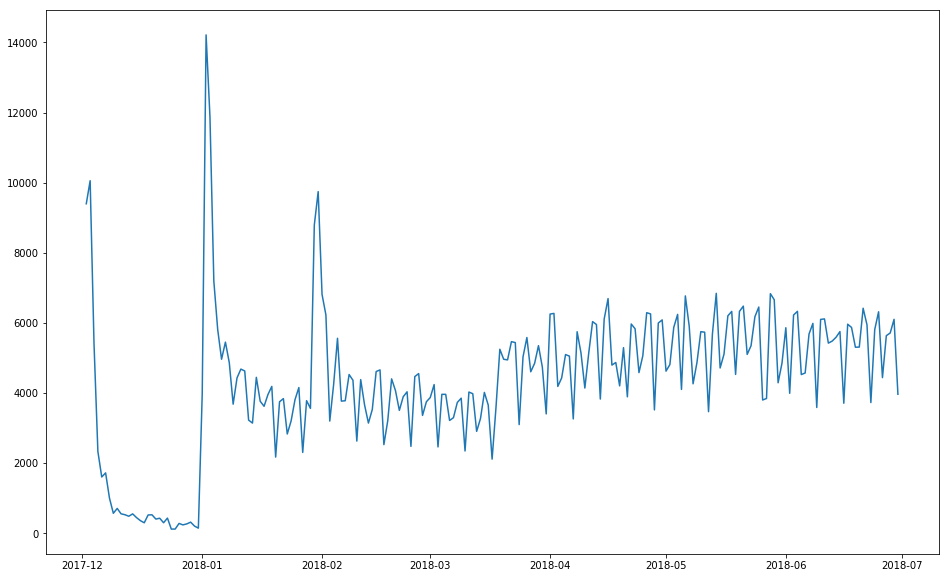

In [19]:
daily_raw = hourly_raw.resample('D').sum()
plt.figure(figsize=(16,10))

plt.plot(daily_raw)

### Hypothesis:
1. As the timeseries dataset is related to ridesharing at the san diego airport, i assume that the traffic around airport would be more during weekdays mainly for business travel and people travelling for leisure prefer to choose weekdays as they are cheaper. Let's assume that to be one hypothesis. ( check the relationship between independent variable Weekdays vs. dependent variable ride count)

2. The traffic activity would be greater during holiday seasons like around christmas time or thanksgiving. Let's assume that to be another hypothesis that we can expect more traffic around holiday season.

3. We can assume that the traffic should show strong seasonal patterns except for the holiday season. 

4. Expect more traffic during morning or night hours as those flights tend to be cheaper. ( check the relationship between independent variable time of the day/ Hour vs. dependent variable ride count)

### Feature creation

From the above hypothesis we can understand that we need more variables to make better understanding of the data to see if our hyptothesis are true or false 


In [58]:
# Lets breakdown the given timeseries object in year,month,day and hour to create more features thus
# simplifying the prediction process further
    
hourly_raw['year']= [x.year for x in hourly_raw["TimeStamp"]]
hourly_raw['month']= [x.month for x in hourly_raw["TimeStamp"]]
hourly_raw['day']= [x.day for x in hourly_raw["TimeStamp"]]
hourly_raw['hour']= [x.hour for x in hourly_raw["TimeStamp"]]

#Lets now get the day of the week
hourly_raw['day of week']=hourly_raw['TimeStamp'].dt.dayofweek+1

#Lets get a column stating if the given date belongs to a weekend(1) or a weekday(0)
def weekend_check(row):
    if row ==6 or row ==7:
        return 1
    else:
        return 0

hourly_raw['weekend']=hourly_raw['TimeStamp'].apply(weekend_check)    


In [59]:
hourly_raw.head()

,TimeStamp,Count,year,month,day,hour,day of week,weekend
EntryDateTime,,,,,,,,
2017-12-02 15:00:00,2017-12-02 15:00:00,478,2017,12,2,15,6,0
2017-12-02 16:00:00,2017-12-02 16:00:00,2531,2017,12,2,16,6,0
2017-12-02 17:00:00,2017-12-02 17:00:00,1374,2017,12,2,17,6,0
2017-12-02 18:00:00,2017-12-02 18:00:00,1468,2017,12,2,18,6,0
2017-12-02 19:00:00,2017-12-02 19:00:00,1280,2017,12,2,19,6,0


In [60]:
hourly_raw.resample('D').sum().head(40)

,Count,year,month,day,hour,day of week,weekend
EntryDateTime,,,,,,,
2017-12-02,9396,18153,108,18,171,54,0
2017-12-03,10054,48408,288,72,276,168,0
2017-12-04,5403,48408,288,96,276,24,0
2017-12-05,2327,48408,288,120,276,48,0
2017-12-06,1599,48408,288,144,276,72,0
2017-12-07,1716,48408,288,168,276,96,0
2017-12-08,996,48408,288,192,276,120,0
2017-12-09,563,48408,288,216,276,144,0
2017-12-10,701,48408,288,240,276,168,0
